이번 챕터에서 배우는 내용은 선형 회귀에 한정되는 내용은 아닙니다. 이번 챕터에서는 데이터를 로드하는 방법과 미니 배치 경사 하강법(Minibatch Gradient Descent)에 대해서 학습합니다.

# 1. 미니 배치와 배치 크기(Mini Batch and Batch Size)

---

앞서 배운 다중 선형 회귀에서 사용했던 데이터를 상기해봅시다.

In [2]:
# x_train = torch.FloatTensor([[73, 80, 75],
#                              [93, 88, 93],
#                              [89, 91, 90],
#                              [96, 98, 100],
#                              [73, 66, 70]])
# y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

위 데이터의 샘플의 개수는 5개입니다. 전체 데이터를 하나의 행렬로 선언하여 전체 데이터에 대해서 경사 하강법을 수행하여 학습할 수 있습니다. 그런데 위 데이터는 현업에서 다루게 되는 방대한 양의 데이터에 비하면 굉장히 적은 양입니다. 만약, 데이터가 수십만개 이상이라면 전체 데이터에 대해서 경사 하강법을 수행하는 것은 매우 느릴 뿐만 아니라 많은 계산량이 필요합니다. 정말 어쩌면 메모리의 한계로 계산이 불가능한 경우도 있을 수 있습니다.

그렇기 때문에 전체 데이터를 더 작은 단위로 나누어서 해당 단위로 학습하는 개념이 나오게 되었습니다.
이 단위를 미니 배치(Mini Batch)라고 합니다.

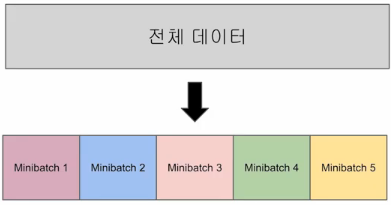

위의 그림은 전체 데이터를 미니 배치 단위로 나누는 것을 보여줍니다. 미니 배치 학습을 하게되면 미니 배치만큼만 가져가서 미니 배치에 대한 대한 비용(cost)를 계산하고, 경사 하강법을 수행합니다. 그리고 다음 미니 배치를 가져가서 경사 하강법을 수행하고 마지막 미니 배치까지 이를 반복합니다. 이렇게 전체 데이터에 대한 학습이 1회 끝나면 1 에포크(Epoch)가 끝나게 됩니다.

+ **에포크(Epoch)는 전체 훈련 데이터가 학습에 한 번 사용된 주기를 말한다고 언급한 바 있습니다.**

미니 배치 학습에서는 미니 배치의 개수만큼 경사 하강법을 수행해야 전체 데이터가 한 번 전부 사용되어 1 에포크(Epoch)가 됩니다. 미니 배치의 개수는 결국 미니 배치의 크기를 몇으로 하느냐에 따라서 달라지는데 미니 배치의 크기를 배치 크기(batch size)라고 합니다.

+ **전체 데이터에 대해서 한 번에 경사 하강법을 수행하는 방법을 '배치 경사 하강법'이라고 부릅니다. 반면, 미니 배치 단위로 경사 하강법을 수행하는 방법을 '미니 배치 경사 하강법'이라고 부릅니다.**

+ **배치 경사 하강법은 경사 하강법을 할 때, 전체 데이터를 사용하므로 가중치 값이 최적값에 수렴하는 과정이 매우 안정적이지만, 계산량이 너무 많이 듭니다. 미니 배치 경사 하강법은 경사 하강법을 할 때, 전체 데이터의 일부만을 보고 수행하므로 최적값으로 수렴하는 과정에서 값이 조금 헤매기도 하지만 훈련 속도가 빠릅니다.**

+ 배치 크기는 보통 2의 제곱수를 사용합니다. ex) 2, 4, 8, 16, 32, 64... 그 이유는 CPU와 GPU의 메모리가 2의 배수이므로 배치크기가 2의 제곱수일 경우에 데이터 송수신의 효율을 높일 수 있다고 합니다.

# 2. 이터레이션(Iteration)

---

미니 배치와 배치 크기의 정의에 대해서 이해하였다면 이터레이션(iteration)을 정의할 수 있습니다.

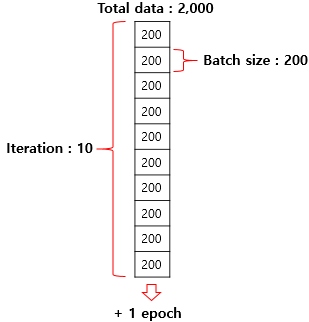

위의 그림은 에포크와 배치 크기와 이터레이션의 관계를 보여줍니다. 위의 그림의 예제를 통해 설명해보겠습니다.

이터레이션은 한 번의 에포크 내에서 이루어지는 매개변수인 가중치 $W$와 $b$의 업데이트 횟수입니다. 전체 데이터가 2,000일 때 배치 크기를 200으로 한다면 이터레이션의 수는 총 10개입니다. 이는 한 번의 에포크 당 매개변수 업데이트가 10번 이루어짐을 의미합니다.

이제 미니 배치 학습을 할 수 있도록 도와주는 파이토치의 도구들을 알아봅시다.

# 3. 데이터 로드하기(Data Load)

---

파이토치에서는 데이터를 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 데이터셋(Dataset)과 데이터로더(DataLoader)를 제공합니다. 이를 사용하면 **미니 배치 학습**, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것입니다.

Dataset을 커스텀하여 만들 수도 있지만 여기서는 텐서를 입력받아 Dataset의 형태로 변환해주는 TensorDataset을 사용해보겠습니다.

실습을 위해 기본적으로 필요한 파이토치의 도구들을 임포트합니다.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

TensorDataset과 DataLoader를 임포트합니다.

In [4]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

TensorDataset은 기본적으로 텐서를 입력으로 받습니다. 텐서 형태로 데이터를 정의합니다.

In [5]:
x_train  =  torch.FloatTensor([[73,  80,  75], 
                               [93,  88,  93], 
                               [89,  91,  90], 
                               [96,  98,  100],   
                               [73,  66,  70]])  
y_train  =  torch.FloatTensor([[152],  [185],  [180],  [196],  [142]])

이제 이를 TensorDataset의 입력으로 사용하고 dataset으로 저장합니다.

In [7]:
dataset = TensorDataset(x_train, y_train)

파이토치의 데이터셋을 만들었다면 데이터로더를 사용 가능합니다. 데이터로더는 기본적으로 2개의 인자를 입력받는다. 하나는 데이터셋, 미니 배치의 크기입니다. 이때 미니 배치의 크기는 통상적으로 2의 배수를 사용합니다. (ex) 64, 128, 256...) 그리고 추가적으로 많이 사용되는 인자로 shuffle이 있습니다. shuffle=True를 선택하면 Epoch마다 데이터셋을 섞어서 데이터가 학습되는 순서를 바꿉니다.

사람도 같은 문제지를 계속 풀면 어느 순간 문제의 순서에 익숙해질 수 있습니다. 예를 들어 어떤 문제지의 12번 문제를 풀면서, '13번 문제가 뭔지는 기억은 안 나지만 어제 풀었던 기억으로 정답은 5번이었던 것 같은데' 하면서 문제 자체보단 순서에 익숙해질 수 있다는 것입니다. 그럴 때 문제지를 풀 때마다 문제 순서를 랜덤으로 바꾸면 도움이 될 겁니다. 마찬가지로 모델이 데이터셋의 순서에 익숙해지는 것을 방지하여 학습할 때는 이 옵션을 True를 주는 것을 권장합니다.

In [8]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

이제 모델과 옵티마이저를 설계합니다.

In [9]:
model = nn.Linear(3,1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 

이제 훈련을 진행합니다. 아래 코드에서는 batch_idx와 samples를 주석 처리했는데 어떤 식으로 훈련되고 있는지 궁금하다면 주석 처리를 해제하고 훈련시켜보시기 바랍니다.

In [12]:
nb_epochs = 20
for epoch in range(nb_epochs + 1):
  for batch_idx, samples in enumerate(dataloader):
    print("batch_idx: ", batch_idx)
    print("samples: ", samples)
    x_train, y_train = samples
    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.mse_loss(prediction, y_train)

    # cost로 H(x) 계산
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.item()
        ))

batch_idx:  0
samples:  [tensor([[ 73.,  66.,  70.],
        [ 96.,  98., 100.]]), tensor([[142.],
        [196.]])]
Epoch    0/20 Batch 1/3 Cost: 2.262544
batch_idx:  1
samples:  [tensor([[73., 80., 75.],
        [93., 88., 93.]]), tensor([[152.],
        [185.]])]
Epoch    0/20 Batch 2/3 Cost: 3.331684
batch_idx:  2
samples:  [tensor([[89., 91., 90.]]), tensor([[180.]])]
Epoch    0/20 Batch 3/3 Cost: 3.585781
batch_idx:  0
samples:  [tensor([[93., 88., 93.],
        [73., 66., 70.]]), tensor([[185.],
        [142.]])]
Epoch    1/20 Batch 1/3 Cost: 5.395226
batch_idx:  1
samples:  [tensor([[ 73.,  80.,  75.],
        [ 96.,  98., 100.]]), tensor([[152.],
        [196.]])]
Epoch    1/20 Batch 2/3 Cost: 3.335608
batch_idx:  2
samples:  [tensor([[89., 91., 90.]]), tensor([[180.]])]
Epoch    1/20 Batch 3/3 Cost: 1.380453
batch_idx:  0
samples:  [tensor([[ 73.,  66.,  70.],
        [ 96.,  98., 100.]]), tensor([[142.],
        [196.]])]
Epoch    2/20 Batch 1/3 Cost: 3.547735
batch_idx:  1


Cost의 값이 점차 작아집니다. (사실 아직 에포크를 더 늘려서 훈련하면 Cost의 값이 더 작아질 여지가 있습니다. 에포크를 늘려서도 훈련해보세요.) 이제 모델의 입력으로 임의의 값을 넣어 예측값을 확인합니다.

In [13]:
# 임의의 입력 [73, 80, 75]를 선언
new_var =  torch.FloatTensor([[73, 80, 75]]) 
# 입력한 값 [73, 80, 75]에 대해서 예측값 y를 리턴받아서 pred_y에 저장
pred_y = model(new_var) 
print("훈련 후 입력이 73, 80, 75일 때의 예측값 :", pred_y) 

훈련 후 입력이 73, 80, 75일 때의 예측값 : tensor([[154.2980]], grad_fn=<AddmmBackward0>)
